In [898]:
import numpy as np

# Project 1: Where are My Glasses?
## Due: 2020-03-06

![blurred image](https:/github.com/dbindel/cs4220-s20/raw/master/hw/code/proj1/data/blurry.png)

The image above is a blurred version of a picture that
I took at the local SPCA.  As we will see, a naive approach to
de-blurring produces garbage, a characteristic feature of *ill-posed*
problems.  In order to reconstruct the image, we need to *regularize*
the reconstruction, just as we would regularize an ill-posed least squares
problem.  We will use Tikhonov regularization, as described in class.
However, this involves choosing the value of a
regularization parameter.  Your mission is to investigate the dependence
on the parameter, and to investigate three approaches to
choosing this parameter (mostly) automatically.

You are given the file `blurry.png` (the blurred image shown above).
You are responsible for the following deliverables, which can either
by submitted as a Jupyter notebook (recommended) or in standalone code:

- Codes to compute "optimal" values of the regularization
  parameter $\lambda$ via the discrepancy principle, the L-curve,
  and generalized cross-validation.
- A report that addresses the questions posed in the rest of this
  prompt.

This project is inspired by the project on image deblurring by James
G. Nagy and Dianne P. O'Leary 
([Image Deblurring: I Can See Clearly Now](http://ieeexplore.ieee.org/document/1196312/))
in _Computing in Science and Engineering_; Project: Vol. 5,
No. 3, May/June 2003, pp. 82-85; Solution: Vol. 5, No. 4, July/August
2003).  Other useful references include:

- Hansen, Nagy, O'Leary.  [*Deblurring Images: Matrices, Spectra, and Filtering*](http://epubs.siam.org/doi/book/10.1137/1.9780898718874), SIAM 2006.
- Hansen and O'Leary.  ["The Use of the L-Curve in the Regularization of Discrete Ill-Posed Problems"](http://epubs.siam.org/doi/abs/10.1137/0914086) in *SIAM J. Sci. Comput.*, Vol 14, No. 6, November 1993.
- Golub, Heath, and Wahba. ["Generalized Cross-Validation as a Method for Choosing a Good Ridge Parameter"](http://www.stat.wisc.edu/~wahba/ftp1/oldie/golub.heath.wahba.pdf) in *Technometrics*, Vol. 21, No. 2, May 1979.
- Golub and von Matt. ["Generalized Cross-Validation for Large-Scale Problems"](https://www.jstor.org/stable/pdf/1390722.pdf) in *Journal of Computational and Graphical Statistics*, Vol. 6, No. 1, March 1997.
-  Morozov.  [*Methods for Solving Incorrectly Posed Problems*](https://link.springer.com/book/10.1007%2F978-1-4612-5280-1), Springer-Verlag, 1984.

It should be possible to do this assignment based only on ideas
presented in this prompt and in the lectures.  However,
you are always welcome to use any ideas or code you find in the
literature, including in the references noted above, provided you
give an appropriate citation.

## Python Setup

The Python version of this project uses the Jupyter notebook interface for convenience, run using Python 3.  You are allowed to submit a standalone code file if you would prefer not to use Jupyter.  To run the notebook, you will need to make sure that a few packages are installed:

- [Pillow](https://pillow.readthedocs.io/en/stable/): Python Imaging Library
- [Numpy](https://numpy.org/): Scientific computing in Python
- [MatPlotLib](https://matplotlib.org/): Create plots in Python


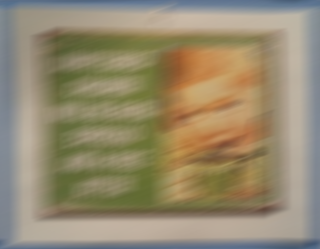

In [924]:
from PIL import Image
import requests
from IPython.display import display
from io import BytesIO
response = requests.get("https://github.com/dbindel/cs4220-s20/raw/master/hw/code/proj1/data/blurry.png")
blurry_img = Image.open(BytesIO(response.content))
display(blurry_img)

## Image array manipulation

Images are represented in Pillow (a Python image processing library) as three-dimensional arrays of color values.  In the default representation of the PNG file that we downloaded, each pixel color represented by a triple of RGB integer value in the range $[0, 255]$. In the $n\times m\times 3$ array, the $n$ and $m$ coordinates specify the the pixel location in the image, while the last coordinate specifies the color channel. To convert a Pillow Image to a Numpy array for manipulation, use the command $\text{np.array()}$.

In [922]:
type(blurry_img)

PIL.PngImagePlugin.PngImageFile

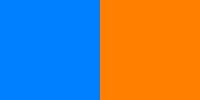

In [923]:
import numpy as np
from PIL import Image
from IPython.display import display

#Example
array = np.zeros([100, 200, 3], dtype=np.uint8)
array[:,:100] = [0, 128, 255]
array[:,100:] = [255, 128, 0] 

img = Image.fromarray(array)
display(img)
#array = np.zeros([20, 20, 3], dtype = np.uint8)
#img2 = Image.fromarray(array)
#display(img2)

The picture was generated by a blurring operation that works on each color plane independently.  To deblur, we want to work on the arrays for one color plane at a time.  Therefore, we will manipulate the data in terms of three floating-point arrays (one each for the red, green, and blue levels), which we construct via the `channelview` function.  The `colorview` function maps these floating point arrays back to a viewable image.  We define a convenience function `arrays_to_img` that does this conversion and makes sure that all the entries of the arrays are clipped back to the interval from 0 to 1.

npixels 79680


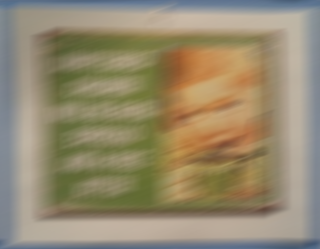

In [915]:
# Convenience function to count pixels
def img_rgb_pixels(V):
    return V.shape[0]*V.shape[1]


# Convert 3-array representation to ordinary colorview representation
def arrays_to_img(V):
    V = (255*V).astype(np.uint8)
    V[V > 255] = 255
    V[V<0] = 0
    img = Image.fromarray(V)
    return img

# Compute the 3-array representation of the blurry image and illustrate the above helpers
blurry_rgb = np.array(blurry_img)/255
print("npixels " + str(img_rgb_pixels(blurry_rgb)))
arrays_to_img(blurry_rgb)

## Blurring, convolution, and Fourier transforms

The image was blurred by *convolving* with a blurring kernel and then rounding the result.  That is, the map from the original pixels $x_{ij}$ to the blurred pixels $y_{ij}$ is given by
$$
  y_{ij} = (k*x)_{ij} = \sum_{k,l} k_{kl} x_{i-k,j-l}
$$
The kernel is in the `K.mat` file in the `proj1/data` subdirectory in the repository, and corresponds to the type of blurring that one sees with motion blur: each pixel in the output is the average of a few pixels along a diagonal line in the image.

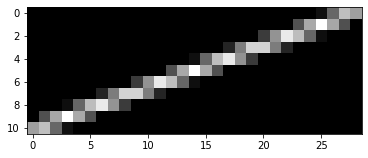

In [916]:
import matplotlib.pyplot as plt

K = np.loadtxt("../data/Km.txt")

plt.imshow(K, cmap="gray")
plt.show()

The function represented by the matrix $K$ is sometimes called the *point spread function* or PSF.  It turns out that the convolution operation $k*x$ -- which we will generally denote as a linear operation $H$ that maps images to images -- can be done very quickly via Fourier transforms: $(\hat{k*x})_{ij} = \hat{k}_{ij} \hat{x}_{ij} = s_{ij} \hat{x}_{ij}$.  Therefore, we will want to keep around a 2D Fourier transform of the (padded) kernel matrix for fast operations with $H$.

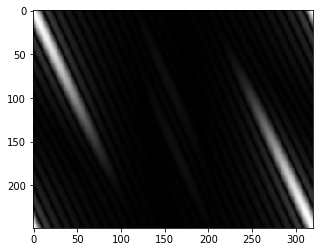

In [918]:
def get_psf_fft(img, K):
    K = np.array(K)
    aimg = np.array(img)
    h, w, k = aimg.shape 
    center = (np.array(K.shape) +1)/2
    PSF = np.zeros((h, w))
    PSF[0:K.shape[0], 0:K.shape[1]] = K
    x = np.array(1 - center).astype(int)
    r = np.roll(PSF, x[0], axis=0)
    r = np.roll(r, x[1], axis=1)
    PSFfft = np.fft.fft2(r)
    return np.array(PSFfft)

s = get_psf_fft(blurry_img, K)
plt.imshow(np.real(np.absolute(s)), cmap="gray")
plt.show()



## Regularization and deblurring

In practice we do not store the exact values produced by the blurring operation $H$.
Instead, if $V^{\mathrm{orig}}$ is the true input image (represented as three columns, one per plane) and $V^{\mathrm{blur}}$ is the blurred image, we actually have
$$
  V^{\mathrm{blur}} = \operatorname{round}(H V^{\mathrm{orig}}),
$$
where the rounding operation maps to the nearest 8-bit fixed point representation.
As described above, our blurring operation is
a *convolution*, which can be diagonalized by a Fourier transform $Z$;
that is,
$$
  H = Z^{*} S Z
$$
where $Z$ is a unitary matrix ($Z^* Z = I$) whose action can be applied
by the two-dimensional fast Fourier transform and $S$ is a diagonal
matrix of eigenvalues.  The matrix $H$ is not symmetric, so the
eigenvalues are complex!

The simplest reconstruction approach is to simply solve
$$
  V^{\mathrm{naive}} \approx H^{-1} V^{\mathrm{blur}}.
$$
which we can do programmatically by

- Transforming $V^{\mathrm{blur}}$ into the Fourier basis: $\hat{V} = Z V^{\mathrm{blur}}$.
- Forming $U = S^{-1} V$ (i.e. scaling each element of $V$).
- Transforming back: $V^{\mathrm{naive}} = Z^* U$.

In fact, we can do many of the manipulations in this assignment working entirely with
transformed images $\hat{V} = ZV$ at intermediate stages, and only transforming back
to real space at the very end.  However, if we want to work this way, it is important
to realize that the `fft` function actually applies a scaled version of $Z$; that is,
$$
  \mbox{fft}(V) = \sqrt{N_\mbox{pixels}} ZV
$$
and the inverse FFT similarly divides by the square root of the number of pixels.

A better approach to deblurring the image is *Tikhonov regularization*:
$$
  V^{\mathrm{tik}}(\lambda) =
  \operatorname{argmin}_V \|HV-V^{\mathrm{blur}}\|_F^2 + \lambda^2 \|V\|_F^2.
$$
We will now investigate why this approach is better.

In [919]:
def img_fft(V):
    return np.fft.fft2(V)/np.sqrt(img_rgb_pixels(V))
def img_ifft(V):
     return np.fft.ifft2(V)*np.sqrt(img_rgb_pixels(V))

# Compute scaling factors for deblurring and residual in Fourier space
def deblur_factors(s, lmbda):
    x = np.conj(s)/(np.conj(s)*s + lmbda**2)
    return x

def resid_factors(s, lmbda):
    s = np.array(s)
    return lmbda**2/((np.conj(s)*s)+lmbda**2)
    
def resid(V, s, λ):
    return img_ifft(resid_fft(img_fft(V), s, λ))

# Compute dot products and norms from an FFT-transformed image
def dot_fft(Vt1, Vt2):
    return np.dot(np.ndarray.flatten(Vt1), np.ndarray.flatten(Vt2))

def normF_fft(Vt):
    return np.sqrt(np.real(dot_fft(Vt, Vt)))

def blur_fft(Vt, s):
    for i in range(3):
        Vt[:, :, i] = s*Vt[:, :, i]
    return Vt

def resid_norm_fft(Vt, s, λ):
    return normF_fft(blur_fft(Vt, resid_factors(s, λ)))

#apply Tikhonov deblurring with parameter lambda to image with array representation V
def p1tikhonov(V, s, lmbda):
    b = V.copy()
    imresult = V.copy()
    for i in range(3):
        bhat = img_fft(b[:, :, i])
        s = deblur_factors(s, lmbda)
        X = s*bhat
        imresult[:, :, i] = np.real(img_ifft(X))
    return imresult    

def deblur_img(V, s, lmbda):
    return arrays_to_img(p1tikhonov(V, s, lmbda))



#### Questions/tasks

These tasks use the following functions to compute the Tikhonov deblurred image as three color plane arrays and as an image array, respectively.

1. Generate a deblurred image by running the first cell below (with $\lambda = 0$).  Ideally, this naive deblurring approach should reproduce the original image.  Does it?  What happens when you run the next cell (with $\lambda = 0.01$)?

2. Using your understanding of the normal equations and of the eigenvalue decomposition of $H$, explain why the function `deblur` actually does solve the Tikhonov minimization problem.

3. Because of rounding, the blurred image actually looks like
$$
    V^{\mathrm{blur}} = HV^{\mathrm{orig}} + E
$$
where $E$ is a backward error.  What is the maximum error per pixel
(assuming no rounding error in applying $H$)?  What is a natural
bound on $\|E\|_F^2$?

4. Using the decomposition $H = Z^* S Z$, what are the singular values of $H$?  The eigenvalues of $H$ are in the `s` array --- what is the smallest singular value?

5. Based on the error bound on $\|E\|_F^2$ and the value of the smallest singular value, provide a bound on $\|V^{\mathrm{orig}}-V^{\mathrm{naive}}\|_F$.  Compare to $\|V^{\mathrm{blur}}\|_F$, and argue that the bad behavior of the naive deblurring approach is completely predictable.

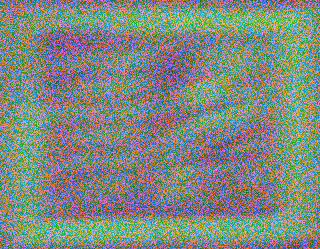

In [920]:
deblur_img(blurry_rgb, s, 0)

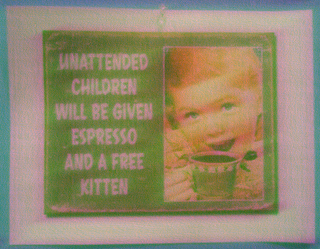

In [921]:
deblur_img(blurry_rgb, s, .01)

## Choosing the parameter

The unsatisfactory feature of Tikhonov regularization is that there
is a free parameter $\lambda$, and so far we have no guidance as to
how to find it.  In the remainder of this project, we consider three
different approaches to finding an "optimal" $\lambda$ according
to three different criteria.

### Morozov's discrepancy principle

Morozov's discrepancy principle says roughly that we should choose $\lambda$ so that the
residual
$$
  \rho(\lambda) = \|HV^{\mathrm{tik}}(\lambda) - V^{\mathrm{blur}}\|_F
$$
is about the same size as the difference between $V^{\mathrm{blur}}$
and the "correct" right hand side.  Usually this distance is difficult
to estimate (which often makes the discrepancy principle hard to apply
in practice), but in our case we already have a good estimate.

#### Questions/tasks

1. Complete the `discrepancy` function below to compute $\lambda$ such that $\rho(\lambda)$ is approximately $\tau = (\sqrt{n/4})$ where $n$ is the number of pixels (this corresponds to assuming the rounded-off quantity is uniformly distributed).  The parameters `λmin` and `λmax` are user-defined lower and upper bounds on the value of the regularization parameter $\lambda$.  Default values of $10^{-4}$ and $1$ span a good range.  You may use the Julia `fzero` routine to find the zero of the equation.

2. What is the optimal $\lambda$ by this criterion? Show the image for the computed regularization parameter.

3. On a log-log scale, plot $\rho(\lambda)$ against $\lambda$ over a "reasonable" range of values around the recommended regularization parameter.  Use a dashed horizontal line to indicate $\tau = (\sqrt{n/4})$, and mark somehow the point on the curve associated with the desired value of $\lambda$.  Are there any visually distinctive features of the plot that suggest this is around the right value?

#### Solutions

We begin by completing the `discrepancy` function to compute $\lambda_{\mathrm{morozov}}$ such that $\rho(\lambda_{\mathrm{morozov}}) = \tau$.

In [853]:
# Compute the threshold for Morozov
def τ_morozov(V):
    return np.sqrt(img_rgb_pixels(V)/4)

# TODO: Find the optimal λ according to the discrepancy principle
def discrepancy(V, s, λmin=1e-4, λmax=1):
    pass


Let's see what the result of regularizing with $\lambda_{\mathrm{morozov}}$ is for our test image.

In [854]:
λ_morozov = discrepancy(blurry_rgb, s)
print("lambda_morozov ="+str(lambda_morozov))
deblur_img(blurry_rgb, s, λ_morozov)

lambda_morozov =None


TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

Finally, we produce a log-log plot of $\rho(\lambda)$ vs $\lambda$ with a dashed horizontal line at $\tau$ and a point marking the computed intersection of the two curves.   The "knee" in the curve is close to the parameter value we chose, which is at least visually suggestive; the fact that we are a bit past the knee perhaps indicates the oversmoothing that we do indeed see.

In [855]:
# Compute a log-spaced array of λ and corresponding residual norms ρ(λ)
blurry_rgbt = img_fft(blurry_rgb)
lambdas = np.exp(np.linspace(np.log(1e-4), np.log(1e0), 20))
rhos = [resid_norm_fft(blurry_rgbt, s, lmbda) for lmbda in lambdas]

#rhos
#Compute the estimated error level for the discrepancy principle
τ = τ_morozov(blurry_rgb)

# TODO: Create the desired plot


### Generalized cross-validation

The *generalized cross-validation criterion* involves minimizing
$$
  G(\lambda) =
  \frac{N \rho(\lambda)^2}
       {\left( \mathrm{tr}(I-H \hat{H}^{\dagger}(\lambda)) \right)^2},
$$
where $\hat{H}^\dagger(\lambda)$ is the solution operator for
the Tikhonov regularized problem ($\hat{H}^\dagger(\lambda) = (H^*H + \lambda^2I)^{-1}H^*$) and $N$ is the number of unknowns
(in this case, three times the number of pixels).  Minimizing $G$ is
easy given the SVD of $H$.  In fact, we know how to compute the SVD
of $H$ in this problem, but in other settings this is not so easy.
So we will seek a different approach.

The troublesome
term is the trace that appears in the denominator, but it turns out
that we can estimate this trace using the fact that if $z$ is any
random vector with independent entries of mean zero and variance one,
then
$$
  \mathrm{tr}(I-H \hat{H}^\dagger(\lambda)) =
  \mathbb{E}\left[ z^T (I-H \hat{H}^\dagger(\lambda)) z \right].
$$
The *Hutchinson* estimator uses random probe vectors consisting
of $\pm 1$ entries to estimate the trace of a large matrix, and Golub
and von Matt suggested a procedure that approximates the GCV criterion
with minimization of
$$
  \tilde{G}(\lambda) =
  \frac{Nm^2 \rho(\lambda)^2}
  {\left( \sum_{l=1}^m z_l^T(I-H \hat{H}^{\dagger}(\lambda)) z_l \right)^2},
$$
where each vector $z_l$ is a $\pm 1$ vector drawn using a pseudo-random
number generator.

#### Questions/tasks

1. Show that
  $$
    \frac{d}{d\lambda} \left( I-H \hat{H}^\dagger(\lambda) \right) =
    2\lambda( \hat{H}^\dagger(\lambda) )^* \hat{H}^\dagger(\lambda).
  $$
  From this, you will be able to compute derivatives of $\rho(\lambda)^2$
  and of $z_\ell^T (I-H \hat{H}^\dagger(\lambda)) z_{\ell}$.  
  *Hint:* The expression for differentiating a matrix inverse
  is in your notes!

2. For a given set of probe vectors stored in a probes $\times$ image size array `Z`, complete the `gcv` routine below to evaluate $\tilde{G}(\lambda)$ and the derivative $\tilde{G}'(\lambda)$.  You should need to employ multiple factorizations per call.

3. Using the `gcv` function as a building block, complete the optimizer `gcvopt` to minimize the $\tilde{G}$.

4. What is the optimal $\lambda$ by this criterion?  Show the image for the computed regularization parameter.

5. On a log-log scale, plot $\tilde{G}(\lambda)$ against $\lambda$ over a "reasonable" range of values around the recommended regularization parameter.  Mark somehow the point on the curve associated with the desired value of $\lambda$.  Is the curve "flat" in the neighborhood of the minimum, or is the minimum clearly defined?

#### Solutions

The `gcv` function returns the estimated GCV function $G(\lambda)$ and its derivative $G'(\lambda)$.  The `gcvopt` function returns the estimate minimizer $\lambda_{\mathrm{gcv}}$ of the GCV function.

In [856]:
# TODO: Return (estimated) G(λ), G'(λ)
def gcv(V, s, λ, Z):
    pass


# TODO: Optimize the GCV for λ between λmin and λmax
def gcvopt(V, s, λmin, λmax, Z):
    pass

We provide some convenience functions to generate a set of probe vectors for the method.  Surprisingly few probes are needed to get reasonable estimates (at least, reasonable for our purposes).  We will default to using 10.

In [857]:
def hutchinson_probes(V, m=10):
    return np.sign(np.random.rand(m, V.shape[0], V.shape[1]) - 0.5)

In [858]:
Z = hutchinson_probes(blurry_rgb)
λ_gcv = gcvopt(blurry_rgb, s, 1e-4, 1, Z)
print("λ_gcv = " + str(λ_gcv))
deblur_img(blurry_rgb, s, λ_gcv)

λ_gcv = None


TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

Finally, we create a log-log plot of $G(\lambda)$ as a function of $\lambda$, and mark the point $(\lambda_{\mathrm{gcv}}, G(\lambda_{\mathrm{gcv}}))$.

In [859]:
# Compute (estimated) G(λ) for a range of λ values and for λ_gcv
λs = np.exp(np.linspace(np.log(1e-4), np.log(1e0), 20))
Gs = [gcvt(blurry_rgbt, s, λ, Zt)[1] for λ in λs]
Gλ_gcv = gcvt(blurry_rgbt, s, λ_gcv, Zt)[1]

# TODO: Produce the plot

NameError: name 'gcvt' is not defined

### The L-curve

The L-curve is a log-log plot of the residual norm ($x$-axis) against
the solution norm ($y$-axis) for varying values of $\lambda$.  It is
named because it tends to look like the letter L.  The vertical part of the L
corresponds to the under-regularized case, where the residual norm
changes negligibly with changes in $\lambda$, but the solution norm
changes dramatically.  The horizontal part corresponds to the
over-regularized case, where small reductions to the solution norm
correspond to increasingly large residuals.  The corner of the L is
the "sweet spot" where the two balance each other, and we seek to
find this by finding $\lambda$ where the curvature is maximal.
You are given a function that computes a point on the
L-curve (and the curvature) associated with a given $\lambda$;
and a function that sweeps out the curve, returning
parallel lists of residual norms, solution norms,
logarithmically-spaced values for $\lambda$, and
curvatures $\kappa(\lambda)$.

#### Questions/tasks

1. Draw a (log-log) plot of the L-curve, and a semi-log plot showing the curvature as a function of the (log) residual norm.  Is there a well-defined corner with a large curvature?

2. Write an optimizer to maximize the curvature (the `lcurveopt` function).  You may use `lcurve` to compute $\kappa$, and you may use existing Julia routines to do the optimization (or you can just use brute force).

3. What is the optimal $\lambda$ by this criterion? Show the image for the computed regularization parameter; is this a good result?

In [860]:
def lcurvet(V, s, λ):
    abs2V = np.absolute(np.array(V))
    
    def wdot(ss):
        slices = np.zeros((abs2V.shape[0], abs2V.shape[1]))
        for i in range(abs2V.shape[2]):
            slices = slices + ss*abs2V[:, :, i]
        return np.real(np.sum((slices)))
            
    C = np.absolute(s) + λ**2

    # Compute the squared solution norm η(λ)^2 and residual norm ρ(λ)^2
    η2 = wdot(np.absolute(s) / C**2)
    ρ2 = wdot((np.absolute(s) / C - 1)**2)
    
    # We also need the first and second derivatives with respect to λ
    dη2 = -4*λ*wdot(np.absolute(s) / C**3)
    dρ2 = -4*λ*wdot((np.absolute(s) / C - 1) * np.absolute(s) / C**2)
    d2η2 = 4*wdot(np.absolute(s) / C**3 * (2*λ / C - 1)) + 8*λ**2*wdot(np.absolute(s) / C**4)
    d2ρ2 = 4*wdot((np.absolute(s) / C - 1)*(np.absolute(s) / C**2 * (2*λ / C - 1))) + 8*λ**2*wdot(np.absolute(s)**2 / C**4)
    
    # The hatted versions that we'd typically plot are log(η) and log(ρ).
    # For computing curvature, it's fine to use ηh = log(η^2) and ρh = log(ρ^2)
    ηh = np.log(η2)
    ρh = np.log(ρ2)
    
    # d(log f) = df/f
    dρh = dρ2/ρ2
    dηh = dη2/η2
    
    # d2(log f) = d2f/f - d(log f)^2
    d2ρh = d2ρ2/ρ2-dρh**2
    d2ηh = d2η2/η2-dηh**2

    # Formula for curvature
    κ = (dρh*d2ηh - d2ρh*dηh)/(dρh**2 + dηh**2)**(1.5)
 
    return np.sqrt(ρ2), np.sqrt(η2), κ

def lcurve(V, s, λ):
    return lcurvet(img_fft(V), s, λ)


#### Solutions

We start with the desired plot of the L-curve.  For context, it is also useful to plot a vertical line at the residual level suggested by the discrepancy principle.

In [861]:
λs = np.exp(np.linspace(np.log(1e-5), np.log(1e0), 50));
ρηκs = [lcurvet(blurry_rgbt, s, λ) for λ in λs]
ρs = [t[0] for t in ρηκs]
ηs = [t[1] for t in ρηκs]
κs = [t[2] for t in ρηκs]

# TODO: Compute λ_lcurve and produce the plot

In [862]:
# TODO: Produce the curvature plot

We plot the result with $\lambda_{\mathrm{lcurve}}$ below, and observe...

In [840]:
print("λ_lcurve " + str(λ_lcurve))
deblur_img(blurry_rgb, s, λ_lcurve)

NameError: name 'λ_lcurve' is not defined

## Notes

1. The type of very ill-conditioned problems seen here occur frequently not only in image reconstruction and inverse problems, but also in solving "first kind" integral equations that occur in mathematical physics.  Integral equations of the second kind tend to be much better behaved.

2. We have sadly passed on a discussion of the use of iterative solvers for treating the large linear systems that arise during the computation of the Tikhonov solutions and during the computations involved in determining the regularization parameter.

3. The types of model selection criteria involved here are useful as well for a variety of problems in machine learning --- though we are not always so blessed with tricks to make everything efficient!

4. As you might gather from our example, though the methods described in this project are mostly robust (hence popular) any regularization method can be fooled.  There is no substitute for checking the answer to see if it looks sensible.